# MIS 583 Assignment 4: Self-supervised and transfer learning on CIFAR10

Before we start, please put your name and SID in following format: <br>
: LASTNAME Firstname, ?00000000   //   e.g.) 李晨愷 M114020035

**Your Answer:**    
Hi I'm 賴壹誠, M124020042.

## Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Setup (5 points)

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import functional
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    #######################################################################
    #        TODO: Implement rotate_img() - return the rotated img        #
    #######################################################################
    if rot == 0:  # 0 degrees rotation
        return img
    elif rot == 1:  # 90 degrees rotation
        return transforms.functional.rotate(img, 90)
    elif rot == 2:  # 180 degrees rotation
        return transforms.functional.rotate(img, 180)
    elif rot == 3:  # 270 degrees rotation
        return transforms.functional.rotate(img, 270)
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')

    #######################################################################
    #                           End of your code                          #
    #######################################################################

class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 80836316.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Show some example images and rotated images with labels:

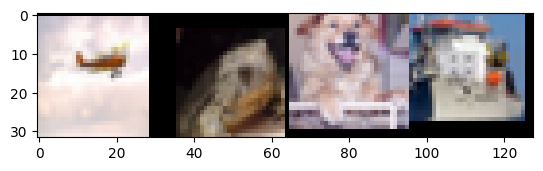

Class labels:  plane frog  dog   ship 


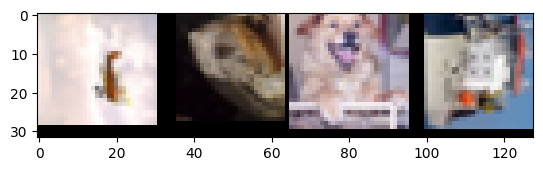

Rotation labels:  270   90    0     270  


In [5]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [6]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            #######################################################################
            # TODO: Calculate outputs by running images through the network       #
            # The class with the highest energy is what we choose as prediction   #
            #######################################################################
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #######################################################################
            #                           End of your code                          #
            #######################################################################
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [7]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train a ResNet18 on the rotation task (9 points)

In this section, we will train a ResNet18 model **from scratch** on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Notice: You should not use pretrained weights from ImageNet.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(weights = None, num_classes=4) # Do not modify this line.
net = net.to(device)
print(net) # print your model and check the num_classes is correct

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
import torch.nn as nn
import torch.optim as optim
################################################################################
# TODO: Define loss and optmizer functions                                     #
# Try any loss or optimizer function and learning rate to get better result    #
# hint: torch.nn and torch.optim                                               #
################################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
################################################################################
#                               End of your code                               #
################################################################################
criterion = criterion.to(device)

In [11]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)
            ######################################################################################################
            # TODO: Set the data to the correct device; Different task will use different inputs and labels      #
            # TODO: Zero the parameter gradients                                                                 #
            # TODO: forward + backward + optimize                                                                #
            # TODO: Get predicted results                                                                        #
            ######################################################################################################
            # Zero the parameter gradients
            optimizer.zero_grad()

            if task == 'rotation':
                # Move data to the correct device
                imgs_rotated, rotation_label = imgs_rotated.to(device), rotation_label.to(device)
                # For rotation task, use imgs_rotated as input
                outputs = net(imgs_rotated)
                loss = criterion(outputs, rotation_label)
            elif task == 'classification':
                # Move data to the correct device
                imgs, cls_label = imgs.to(device), cls_label.to(device)
                # For classification task, use imgs as input
                outputs = net(imgs)
                loss = criterion(outputs, cls_label)
            else:
                raise ValueError(f"Unsupported task: {task}")

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Get predicted results
            _, predicted = outputs.max(1)
            ######################################################################################################
            #                               End of your code                                                     #
            ######################################################################################################

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels.to(device)[:predicted.size(0)]).sum().item()
            #running_correct += (predicted == labels.to(device)).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()
        ######################################################################################################
        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.          #
        ######################################################################################################
        run_test(net, testloader, criterion, task)
        ######################################################################################################
        #                               End of your code                                                     #
        ######################################################################################################

    print('Finished Training')

In [ ]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')
################################
#     TODO: Save the model     #
################################
torch.save(net.state_dict(), 'model.pt')
################################
#      End of your code        #
################################

[1,   100] loss: 1.061 acc: 9.57 time: 9.31
[1,   200] loss: 1.052 acc: 9.53 time: 10.89
[1,   300] loss: 1.029 acc: 9.46 time: 13.57
TESTING:
Accuracy of the network on the 10000 test images: 58.22 %
Average loss on the 10000 test images: 0.996
[2,   100] loss: 1.015 acc: 9.68 time: 9.45
[2,   200] loss: 0.997 acc: 9.70 time: 10.08
[2,   300] loss: 0.994 acc: 9.91 time: 8.78
TESTING:
Accuracy of the network on the 10000 test images: 59.31 %
Average loss on the 10000 test images: 0.955
[3,   100] loss: 0.968 acc: 9.94 time: 10.51
[3,   200] loss: 0.950 acc: 9.70 time: 8.93
[3,   300] loss: 0.956 acc: 10.11 time: 10.81
TESTING:
Accuracy of the network on the 10000 test images: 61.69 %
Average loss on the 10000 test images: 0.912
[4,   100] loss: 0.927 acc: 9.82 time: 9.62
[4,   200] loss: 0.914 acc: 9.60 time: 9.97
[4,   300] loss: 0.913 acc: 9.66 time: 8.81
TESTING:
Accuracy of the network on the 10000 test images: 61.24 %
Average loss on the 10000 test images: 0.924
[5,   100] loss: 0

## Fine-tuning on the pre-trained model (9 points)

In this section, we will load the ResNet18 model pre-trained on the rotation task and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

**Then we will use the trained model from rotation task as the pretrained weights. Notice, you should not use the pretrained weights from ImageNet.**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#####################################################
#     TODO: Load the pre-trained ResNet18 model     #
#####################################################
ckpt = torch.load('model.pt')
net.load_state_dict(ckpt)
net.fc = nn.Linear(512, 10)
net = net.to(device)
print(net) # print your model and check the num_classes is correct
####################################################
#                End of your code                  #
####################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#################################################################################################
#   TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable     #
#################################################################################################
for name, param in net.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
#################################################################################################
#                                          End of your code                                     #
#################################################################################################

In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params_to_update, lr=0.1, momentum=0.9)
criterion = criterion.to(device)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.1, task='classification')


[1,   100] loss: 1.949 acc: 10.45 time: 9.14
[1,   200] loss: 1.886 acc: 10.35 time: 9.40
[1,   300] loss: 1.848 acc: 10.07 time: 7.64
TESTING:
Accuracy of the network on the 10000 test images: 32.70 %
Average loss on the 10000 test images: 1.834
[2,   100] loss: 1.773 acc: 10.09 time: 9.36
[2,   200] loss: 1.771 acc: 10.94 time: 7.74
[2,   300] loss: 1.734 acc: 10.04 time: 8.86
TESTING:
Accuracy of the network on the 10000 test images: 35.05 %
Average loss on the 10000 test images: 1.745
[3,   100] loss: 1.735 acc: 10.33 time: 11.48
[3,   200] loss: 1.692 acc: 10.02 time: 7.42
[3,   300] loss: 1.704 acc: 10.56 time: 9.51
TESTING:
Accuracy of the network on the 10000 test images: 37.49 %
Average loss on the 10000 test images: 1.714
[4,   100] loss: 1.678 acc: 10.57 time: 7.63
[4,   200] loss: 1.675 acc: 10.29 time: 9.73
[4,   300] loss: 1.674 acc: 10.19 time: 7.36
TESTING:
Accuracy of the network on the 10000 test images: 39.39 %
Average loss on the 10000 test images: 1.667
[5,   100] 

## Fine-tuning on the randomly initialized model (9 points)
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18
#################################################
# TODO: Randomly initialize a ResNet18 model    #
#################################################
net = resnet18(weights=None, num_classes=10)
net = net.to(device)
print(net) # print your model and check the num_classes is correct
#################################################
#              End of your code                 #
#################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#################################################################################################
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable       #
# To do this, you should set requires_grad=False for the frozen layers.                         #
#################################################################################################
for name, param in net.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
#################################################################################################
#                                          End of your code                                     #
#################################################################################################


In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params_to_update, lr=0.1, momentum=0.9)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.1, task='classification')

[1,   100] loss: 1.586 acc: 10.27 time: 6.76
[1,   200] loss: 1.650 acc: 9.96 time: 8.43
[1,   300] loss: 1.635 acc: 10.45 time: 9.23
TESTING:
Accuracy of the network on the 10000 test images: 41.49 %
Average loss on the 10000 test images: 1.651
[2,   100] loss: 1.634 acc: 9.67 time: 8.65
[2,   200] loss: 1.629 acc: 10.16 time: 6.57
[2,   300] loss: 1.635 acc: 10.16 time: 10.40
TESTING:
Accuracy of the network on the 10000 test images: 42.60 %
Average loss on the 10000 test images: 1.632
[3,   100] loss: 1.623 acc: 9.93 time: 7.44
[3,   200] loss: 1.614 acc: 9.79 time: 7.72
[3,   300] loss: 1.609 acc: 10.38 time: 7.27
TESTING:
Accuracy of the network on the 10000 test images: 42.35 %
Average loss on the 10000 test images: 1.639
[4,   100] loss: 1.595 acc: 9.74 time: 6.77
[4,   200] loss: 1.622 acc: 9.85 time: 8.08
[4,   300] loss: 1.607 acc: 10.01 time: 6.67
TESTING:
Accuracy of the network on the 10000 test images: 42.77 %
Average loss on the 10000 test images: 1.618
[5,   100] loss: 

## Supervised training on the pre-trained model (9 points)
In this section, we will load the ResNet18 model pre-trained on the rotation task and re-train the whole model on the classification task.

**Then we will use the trained model from rotation task as the pretrained weights. Notice, you should not use the pretrained weights from ImageNet.**

In [12]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#####################################################
#     TODO: Load the pre-trained ResNet18 model     #
#####################################################
ckpt = torch.load('model.pt')
net.load_state_dict(ckpt)
net.fc = nn.Linear(512, 10)
net = net.to(device)
print(net) # print your model and check the num_classes is correct
#####################################################
#                End of your code                   #
#####################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

In [16]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.1, task='classification')

[1,   100] loss: 1.141 acc: 9.93 time: 9.30
[1,   200] loss: 1.141 acc: 10.26 time: 8.80
[1,   300] loss: 1.124 acc: 10.27 time: 8.80
TESTING:
Accuracy of the network on the 10000 test images: 58.98 %
Average loss on the 10000 test images: 1.139
[2,   100] loss: 1.096 acc: 9.85 time: 7.67
[2,   200] loss: 1.110 acc: 10.02 time: 10.13
[2,   300] loss: 1.076 acc: 9.84 time: 7.64
TESTING:
Accuracy of the network on the 10000 test images: 59.25 %
Average loss on the 10000 test images: 1.143
[3,   100] loss: 1.077 acc: 9.98 time: 10.37
[3,   200] loss: 1.076 acc: 9.48 time: 7.52
[3,   300] loss: 1.080 acc: 10.30 time: 10.04
TESTING:
Accuracy of the network on the 10000 test images: 61.30 %
Average loss on the 10000 test images: 1.092
[4,   100] loss: 1.055 acc: 9.77 time: 9.33
[4,   200] loss: 1.022 acc: 10.15 time: 9.17
[4,   300] loss: 1.032 acc: 9.99 time: 8.67
TESTING:
Accuracy of the network on the 10000 test images: 62.23 %
Average loss on the 10000 test images: 1.059
[5,   100] loss:

## Supervised training on the randomly initialized model (9 points)
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#################################################
# TODO: Randomly initialize a ResNet18 model    #
#################################################
net = resnet18(weights=None, num_classes=10)
net = net.to(device)
print(net) # print your model and check the num_classes is correct
#################################################
#              End of your code                 #
#################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 1.999 acc: 10.26 time: 17.28
[1,   200] loss: 1.728 acc: 10.05 time: 10.00
[1,   300] loss: 1.579 acc: 10.00 time: 8.26
TESTING:
Accuracy of the network on the 10000 test images: 49.51 %
Average loss on the 10000 test images: 1.389
[2,   100] loss: 1.436 acc: 9.73 time: 8.72
[2,   200] loss: 1.351 acc: 9.71 time: 10.36
[2,   300] loss: 1.322 acc: 10.11 time: 10.74
TESTING:
Accuracy of the network on the 10000 test images: 57.21 %
Average loss on the 10000 test images: 1.181
[3,   100] loss: 1.230 acc: 10.23 time: 11.44
[3,   200] loss: 1.175 acc: 9.95 time: 7.98
[3,   300] loss: 1.178 acc: 10.21 time: 12.58
TESTING:
Accuracy of the network on the 10000 test images: 61.77 %
Average loss on the 10000 test images: 1.078
[4,   100] loss: 1.091 acc: 10.52 time: 8.06
[4,   200] loss: 1.085 acc: 9.88 time: 10.73
[4,   300] loss: 1.047 acc: 10.16 time: 8.33
TESTING:
Accuracy of the network on the 10000 test images: 64.13 %
Average loss on the 10000 test images: 1.017
[5,   100

# Write report (37 points)

本次作業主要有3個tasks需要大家完成，在A4.pdf中有希望大家達成的baseline **(不能低於baseline最多2%，沒有達到不會給全部分數)**，report的撰寫請大家根據以下要求完成，就請大家將嘗試的結果寫在report裡，祝大家順利！

1. (13 points) Train a ResNet18 on the Rotation task and report the test performance. Discuss why such a task helps in learning features that are generalizable to other visual tasks.

2. (12 points) Initializing from the Rotation model or from random weights, fine-tune only the weights of the final block of convolutional layers and linear layer on the supervised CIFAR10 classification task. Report the test results and compare the performance of these two models. Provide your observations and insights. You can also discuss how the performance of pre-trained models affects downstream tasks, the performance of fine-tuning different numbers of layers, and so on.

3. (12 points) Initializing from the Rotation model or from random weights, train the full network on the supervised CIFAR10 classification task. Report the test results and compare the performance of these two models. Provide your observations and insights.

# Extra Credit (13 points)

上面基本的code跟report最高可以拿到87分，這個加分部分並沒有要求同學們一定要做，若同學們想要獲得更高的分數可以根據以下的加分要求來獲得加分。

- In Figure 5(b) from the Gidaris et al. paper, the authors show a plot of CIFAR10 classification performance vs. number of training examples per category for a supervised CIFAR10 model vs. a RotNet model with the final layers fine-tuned on CIFAR10. The plot shows that pre-training on the Rotation task can be advantageous when only a small amount of labeled data is available. Using your RotNet fine-tuning code and supervised CIFAR10 training code from the main assignment, try to create a similar plot by performing supervised fine-tuning/training on only a subset of CIFAR10.
- Use a more advanced model than ResNet18 to try to get higher accuracy on the rotation prediction task, as well as for transfer to supervised CIFAR10 classification.
  
- If you have a good amount of compute at your disposal, try to train a rotation prediction model on the larger ImageNette dataset (still smaller than ImageNet, though).
